In [8]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from Visualisations import HeatmapVisualizer

In [2]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

start_date = pd.to_datetime(f"2023-02-02 00:00:00")
end_date = pd.to_datetime(f"2023-04-01 23:50:00")
model_features = ["day", "hour", "weekday", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)


In [3]:
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.day
df["window_block"] = ((df['time'].dt.minute * 60 + df['time'].dt.second) // 600).astype(int)

In [4]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=29, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=6, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2023-02-02 00:00:00-2023-03-03 23:50:00, testing: 2023-03-04 00:00:00-2023-03-10 23:50:00.


In [5]:
model = RandomForestClassifier()
model.fit(X_train, y_train) # , sample_weight=np.linspace(0, 1, len(X_train))

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [6]:
for d in range(7):
    # Then, evaluate the baseline's predictions and store acc in self.baseline_performance
    this_day_predictions = predictions[d*144:(d+1)*144]
    this_day_actual_values = y_test[d*144:(d+1)*144]
    acc = accuracy_score(this_day_actual_values, this_day_predictions)
    print(f"Acc for day {d}: {acc}")

Acc for day 0: 0.0
Acc for day 1: 0.05555555555555555
Acc for day 2: 0.8611111111111112
Acc for day 3: 0.6875
Acc for day 4: 0.6875
Acc for day 5: 0.875
Acc for day 6: 0.7777777777777778


Message (heatmap visualizer): Making heatmap with 4320 records, starting at 2023-02-02T00:00:00.000000000 and ending at 2023-03-03T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_training.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-03-04T00:00:00.000000000 and ending at 2023-03-10T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_predicted.png.
Message (heatmap visualizer): Making heatmap with 1008 records, starting at 2023-03-04T00:00:00.000000000 and ending at 2023-03-10T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_actual.png.


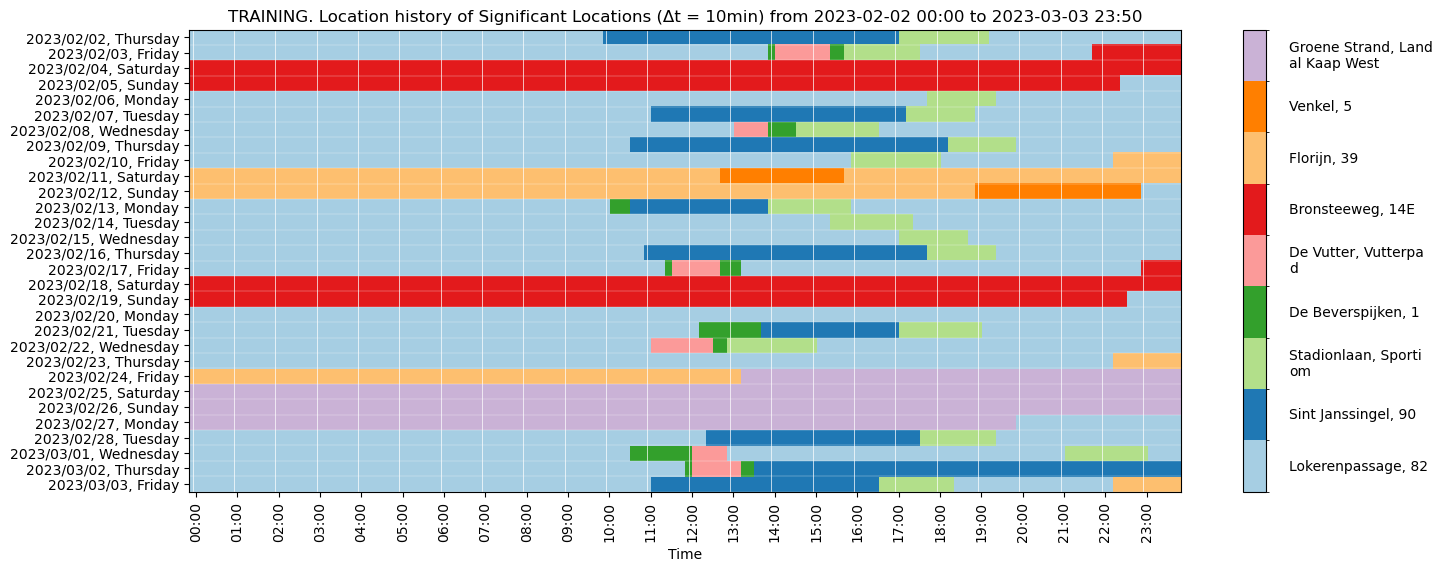

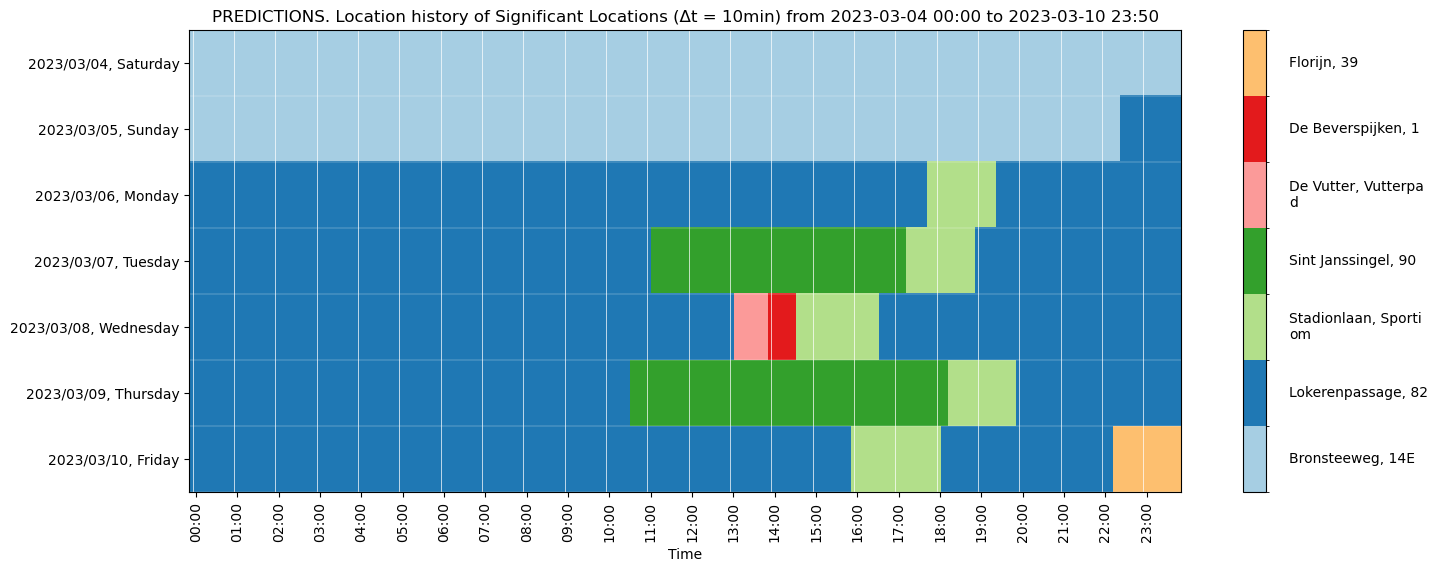

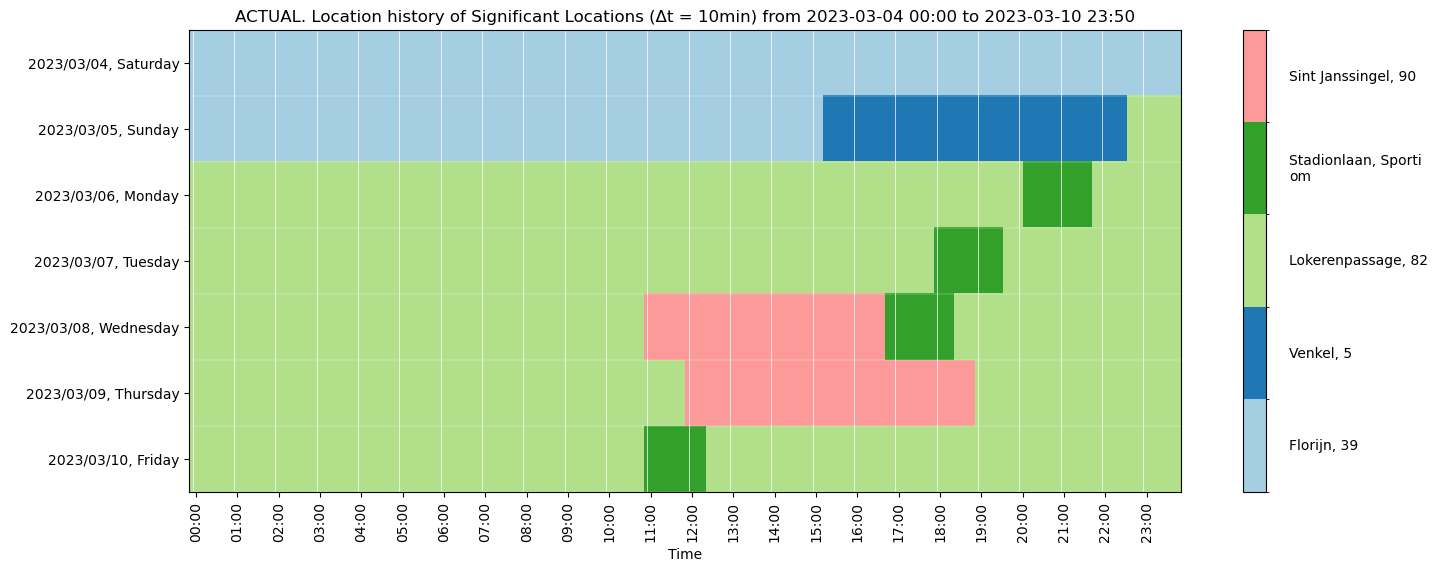

In [12]:
df.location = label_encoder.inverse_transform(df.location)

time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "time": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_training",
    title="TRAINING",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    name="heatmap_predicted",
    title="PREDICTIONS",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_actual",
    title="ACTUAL",
)

In [ ]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

In [ ]:
print(f"Acc random forest classifier: {accuracy_score(y_test, predictions)}")
print(f"Acc dummy model: {accuracy_score(y_test, dummy_predictions)}")

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, dummy_predictions, labels=dummy_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_model.classes_)
disp.plot()
plt.show()